In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
colnames=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'] 
df=pd.read_csv("iris.data", names=colnames, header=None)

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
Y=df["class"]
X=df.drop("class",axis=1)

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#label encoding for 3 class
enc = LabelEncoder()
enc.fit(Y)
Y=np_utils.to_categorical(enc.transform(Y))

In [7]:
Y[0]

array([1., 0., 0.], dtype=float32)

In [8]:
#split the data as train %80 and test data %20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [9]:
# z = (x - u) / s
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
X_train.shape

(120, 4)

In [11]:
class NeuralNetwork():
    def __init__(self, layers, learning_rate, iterations):
        self.params = {} #will include parameters like weight and bias 
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = [] #for loss values
        self.layers = layers # node counts 
        self.sample_size = None
        self.X = None
        self.Y = None
    
    def init_weights_and_bias(self):
        np.random.seed(1)
        #initialize random values
        self.params["w_1"]=np.random.rand(self.layers[0],self.layers[1]) #weight1
        self.params["w_2"]=np.random.rand(self.layers[1],self.layers[2]) #weight2
        #initialize zero
        self.params["b_1"]=np.zeros((self.layers[1],)) #bias1
        self.params["b_2"]=np.zeros((self.layers[2],)) #bias2
    
    def relu(self,Z):
        # it return the value, if it is smaller than zero, it return zero.
        max_val= np.maximum(0,Z)
        return max_val
    
    def relu_derivative(self, z):
        #if greater than 0, return 1, else return 0
        return np.where(z> 0, 1, 0)
    
    def softmax(self,A):
        #normalize the output of a network to a probability distribution over predicted output classes
        expA = np.exp(A)
        return expA / expA.sum(axis=1, keepdims=True)

    def control(self,c):
        c=np.maximum(c,0.0000000001) #return max for avoid mathematical problems
        return c
    
    def forward_propagation(self):
        # Z = wX + b
        Z1 = np.dot(self.X,self.params["w_1"]) + self.params["b_1"]
        # A1 = input of hidden layer
        A1=self.relu(Z1)
        Z2 = np.dot(A1,self.params["w_2"]) + self.params["b_2"]
        # A2 = input of output layer
        A2=self.softmax(Z2)         
        # save calculated parameters
        self.params["z1"]=Z1
        self.params["z2"]=Z2
        self.params["a1"]=A1
        self.params["a2"]=A2
        yhat=A2
        #control for nan values
        yhat=self.control(yhat)
        #calculate loss values
        loss= self.cross_entropy_loss(self.Y,yhat)
        return yhat,loss
    
    def cross_entropy_loss(self, y, yhat):
        #cross entropy= -∑ y* log(yhat)
        loss= -np.sum(np.multiply(np.log(yhat),y))/self.sample_size
        return loss
    
    def back_propagation(self,yhat):
        #calculate derivatives of z,w,b values
        dz2=yhat-self.Y
        dw2=np.dot(self.params["a1"].T,dz2)
        db2=np.sum(dz2, axis=0, keepdims=True)
        dz1=np.dot(dz2,self.params["w_2"].T)*self.relu_derivative(self.params["z1"])
        dw1=np.dot(self.X.T,dz1)
        db1=np.sum(dz1, axis=0, keepdims=True)

        #update 
        self.params["w_1"] = self.params["w_1"]-(self.learning_rate*dw1)
        self.params["w_2"] = self.params["w_2"]-(self.learning_rate*dw2)
        self.params["b_2"] = self.params["b_2"]-(self.learning_rate*db2)
        self.params["b_1"] = self.params["b_1"]-(self.learning_rate*db1)

    def fit(self, X, y):
        self.X = X
        self.Y = y
        self.sample_size = self.Y.shape[1]
        #initialize weights and bias
        self.init_weights_and_bias()
        # loop for count of epoch
        for i in range(self.iterations): 
            yhat, ls = self.forward_propagation()
            self.loss.append(ls)
            self.back_propagation(yhat)
    
    def predict(self, X):
#       Z = wX + b
        newZ=np.dot(X,self.params["w_1"]) + self.params["b_1"]
        newA1=self.relu(newZ)
        newZ2 = np.dot(newA1,self.params["w_2"]) + self.params["b_2"]
        # newA2 = input of output layer
        newA2=self.softmax(newZ2)
        # value with the highest probability=1, others=0 in predictions
        for each in range(X.shape[0]):
            newA2[each] = np.where(newA2[each] == np.max(newA2[each]), 1, 0)
        return newA2
    
    def acc(self, y, yhat):
        #calculate accuracy
        true_sum=0
        for each in range(y.shape[0]):
            if all(y[each]==yhat[each]): #like [0,1,0]==[0,1,0]
                true_sum+=1
        accuracy = (true_sum / len(y)) * 100
        accuracy=round(accuracy,3) #3 digit after zero
        return accuracy
    
    def plot_loss(self):
        plt.plot(self.loss)
        plt.xlabel("Iteration number")
        plt.ylabel("loss value")
        plt.title("Loss plot")
        plt.show()

In [12]:
#[4,5,3]: 4 for node count of input layer(attribute number), 5 for hidden layer and 3 for output layer(class number)
nn=NeuralNetwork([4,5,3], 0.001, 100) #100 forward and backward, with 0.001 learning rate
nn.fit(X_train,y_train)
yhat=nn.predict(X_test)
nn.acc(y_test, yhat) #test accuracy

86.667

In [13]:
yhat_tr=nn.predict(X_train) 
nn.acc(y_train, yhat_tr) #train accuracy

92.5

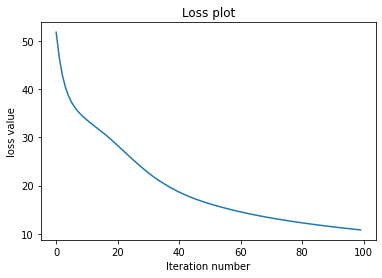

In [14]:
nn.plot_loss()

In [15]:
#[4,5,3]: 4 for node count of input layer(attribute number), 5 for hidden layer and 3 for output layer(class number)
nn2=NeuralNetwork([4,5,3], 0.001, 250)  #250 forward and backward, with 0.001 learning rate
nn2.fit(X_train,y_train)
yhat2=nn2.predict(X_test)
nn2.acc(y_test, yhat2)

100.0

In [16]:
#[4,5,3]: 4 for node count of input layer(attribute number), 5 for hidden layer and 3 for output layer(class number)
nn3=NeuralNetwork([4,5,3], 0.002, 100)  # with 0.002 learning rate, 100 iteration num.
nn3.fit(X_train,y_train)
yhat3=nn3.predict(X_test)
nn3.acc(y_test, yhat3)

100.0

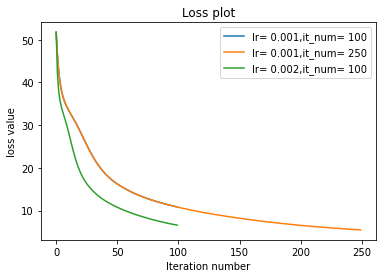

In [17]:
plt.plot(nn.loss,label="lr= 0.001,it_num= 100")
plt.plot(nn2.loss,label="lr= 0.001,it_num= 250")
plt.plot(nn3.loss,label="lr= 0.002,it_num= 100")
plt.xlabel("Iteration number")
plt.ylabel("loss value")
plt.title("Loss plot")
plt.legend()
plt.show()